In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [4]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [5]:
def run(calc_correlation=True):

    model_params = dict(conserve=None, Jx=0.001, Jy=1.001, Jz=0.999, L=1, verbose=1)
    prod_state = ["up", "down"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-12, # reduce this when the bond dimension is increased
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-5,
        'max_sweeps': 5000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = np.arange(16, 64, 4)
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [6]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    

In [7]:
data = run()

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=4 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=0.001 for KitaevLadderModel
parameter 'Jy'=1.001 for KitaevLadderModel
parameter 'Jz'=0.999 for KitaevLadderModel


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-12} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=5000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-05 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591734504766036, S = nan, norm_err = 2.2e-06
Current memory usage 144.5 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8174e-05, max_E_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
DMRG finished after 50 sweeps.
total size = 2896, maximum chi = 20
Before the canonicalization:
Bond dim =  [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.00000000000049-4.4182834219772135e-17j)
After the canonicalization:
Bond dim =  [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Computing properties
Optimizing
Loop for chi=20 done.
============================== END ==============================


==============================START==============================
Chi =  24 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591802248996013, S = nan, norm_err = 6.2e-05
Current memory usage 146.6 MB, time elapsed: 7.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5148e-06, max_E_trunc = 1.5508e-06
MPS bond dimensions: [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
Updating environment
.....
s

Updating environment
.....
sweep 20, age = 1296
Energy = -0.1591808709323717, S = nan, norm_err = 1.4e-05
Current memory usage 147.3 MB, time elapsed: 15.9 s
Delta E = -9.0682e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8452e-06, max_E_trunc = 1.1958e-06
MPS bond dimensions: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 1776
Energy = -0.1591808706892266, S = 1.6212847083672850, norm_err = 1.1e-06
Current memory usage 147.3 MB, time elapsed: 20.7 s
Delta E = 2.4315e-11, Delta S = nan (per sweep)
max_trunc_err = 9.3170e-07, max_E_trunc = 1.2072e-06
MPS bond dimensions: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Updating environment
.....
sweep 40, age = 2256
Energy = -0.1591808680633982, S = 1.6219247786151005, norm_err = 2.7e-06
Current memory usage 147.3 MB, time elapsed: 25.8 s
Delta E = 2.6258e-10, Delta S = 6.400

Updating environment
.....
sweep 120, age = 6096
Energy = -0.1591811437542425, S = 1.6502258889055714, norm_err = 5.8e-04
Current memory usage 148.3 MB, time elapsed: 69.9 s
Delta E = -1.3777e-12, Delta S = -3.8816e-04 (per sweep)
max_trunc_err = 6.2037e-07, max_E_trunc = 7.7882e-07
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 130, age = 6576
Energy = -0.1591811437708515, S = 1.6445494759286061, norm_err = 6.9e-04
Current memory usage 148.8 MB, time elapsed: 75.1 s
Delta E = -1.6609e-12, Delta S = -5.6764e-04 (per sweep)
max_trunc_err = 6.2039e-07, max_E_trunc = 7.7884e-07
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 140, age = 7056
Energy = -0.1591811437890556, S = 1.6363586480502819, norm_err = 8.1e-04
Current memory usage 148.9 MB, time elapsed: 80.3 s
Delta E = -1.8204e-12, Delta S = -8.1908e-04 (per sweep)
max_trunc_err = 6.2040e-07, m

Updating environment
.....
sweep 310, age = 15216
Energy = -0.1591816884432546, S = 1.2113408766348202, norm_err = 3.9e-04
Current memory usage 152.2 MB, time elapsed: 179.6 s
Delta E = -9.6290e-11, Delta S = 8.2726e-04 (per sweep)
max_trunc_err = 3.1674e-08, max_E_trunc = 4.0508e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 320, age = 15696
Energy = -0.1591816891869087, S = 1.2164493623496675, norm_err = 3.2e-04
Current memory usage 153.1 MB, time elapsed: 185.5 s
Delta E = -7.4365e-11, Delta S = 5.1085e-04 (per sweep)
max_trunc_err = 3.2670e-08, max_E_trunc = 4.1830e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 330, age = 16176
Energy = -0.1591816897877720, S = 1.2217268003168296, norm_err = 2.6e-04
Current memory usage 153.4 MB, time elapsed: 190.9 s
Delta E = -6.0086e-11, Delta S = 5.2774e-04 (per sweep)
max_trunc_err = 3.3691e-08

Updating environment
.....
sweep 500, age = 24336
Energy = -0.1591816934750341, S = 1.2669673932038847, norm_err = 8.6e-05
Current memory usage 157.4 MB, time elapsed: 283.9 s
Delta E = -8.2053e-12, Delta S = 1.4360e-04 (per sweep)
max_trunc_err = 4.2750e-08, max_E_trunc = 5.4903e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 510, age = 24816
Energy = -0.1591816935475663, S = 1.2682684517747642, norm_err = 5.1e-05
Current memory usage 157.6 MB, time elapsed: 289.1 s
Delta E = -7.2532e-12, Delta S = 1.3011e-04 (per sweep)
max_trunc_err = 4.3025e-08, max_E_trunc = 5.5265e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 520, age = 25296
Energy = -0.1591816936026049, S = 1.2694080575306843, norm_err = 9.1e-06
Current memory usage 157.6 MB, time elapsed: 294.2 s
Delta E = -5.5039e-12, Delta S = 1.1396e-04 (per sweep)
max_trunc_err = 4.3286e-08

Updating environment
.....
sweep 690, age = 33456
Energy = -0.1591816942568016, S = 1.2844678007386752, norm_err = 1.7e-04
Current memory usage 161.9 MB, time elapsed: 391.3 s
Delta E = 2.2027e-12, Delta S = 8.9568e-05 (per sweep)
max_trunc_err = 4.6232e-08, max_E_trunc = 5.9428e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 700, age = 33936
Energy = -0.1591816943300159, S = 1.2840875222350168, norm_err = 8.5e-05
Current memory usage 162.2 MB, time elapsed: 397.1 s
Delta E = -7.3214e-12, Delta S = -3.8028e-05 (per sweep)
max_trunc_err = 4.6252e-08, max_E_trunc = 5.9456e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 710, age = 34416
Energy = -0.1591816943449658, S = 1.2844656349536714, norm_err = 3.1e-05
Current memory usage 162.4 MB, time elapsed: 402.6 s
Delta E = -1.4950e-12, Delta S = 3.7811e-05 (per sweep)
max_trunc_err = 4.6381e-08

Updating environment
.....
sweep 880, age = 42576
Energy = -0.1591816945356470, S = 1.2912886035140994, norm_err = 1.4e-04
Current memory usage 167.7 MB, time elapsed: 505.9 s
Delta E = 2.4471e-12, Delta S = 3.3989e-05 (per sweep)
max_trunc_err = 4.7654e-08, max_E_trunc = 6.1283e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 890, age = 43056
Energy = -0.1591816945595497, S = 1.2909947275007576, norm_err = 6.7e-05
Current memory usage 167.9 MB, time elapsed: 511.8 s
Delta E = -2.3903e-12, Delta S = -2.9388e-05 (per sweep)
max_trunc_err = 4.8084e-08, max_E_trunc = 6.1909e-08
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 900, age = 43536
Energy = -0.1591816945753806, S = 1.2913922115030219, norm_err = 3.7e-05
Current memory usage 168.0 MB, time elapsed: 517.0 s
Delta E = -1.5831e-12, Delta S = 3.9748e-05 (per sweep)
max_trunc_err = 4.7630e-08

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.70e-05
Call psi.canonical_form()
DMRG finished after 940 sweeps.
total size = 46256, maximum chi = 36
Before the canonicalization:
Bond dim =  [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000003+2.992397996059992e-16j)
After the canonicalization:
Bond dim =  [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Computing properties
Optimizing
Loop for chi=36 done.
============================== END ==============================


==============================START==============================
Chi =  40 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591816351005355, S = nan, norm_err = 1.3e-03
Current memory usage 169.1 MB, time e

Updating environment
.....
sweep 170, age = 8496
Energy = -0.1591817086152219, S = 1.3066283667566265, norm_err = 2.5e-04
Current memory usage 169.3 MB, time elapsed: 114.9 s
Delta E = -2.9526e-10, Delta S = 2.2526e-04 (per sweep)
max_trunc_err = 3.2022e-08, max_E_trunc = 3.6828e-08
MPS bond dimensions: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Updating environment
.....
sweep 180, age = 8976
Energy = -0.1591817084034517, S = 1.3060731455874364, norm_err = 3.6e-04
Current memory usage 169.3 MB, time elapsed: 120.7 s
Delta E = 2.1177e-11, Delta S = -5.5522e-05 (per sweep)
max_trunc_err = 3.1939e-08, max_E_trunc = 3.6747e-08
MPS bond dimensions: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Updating environment
.....
sweep 190, age = 9456
Energy = -0.1591817084068694, S = 1.3070991461461274, norm_err = 5.1e-04
Current memory usage 169.3 MB, time elapsed: 126.6 s
Delta E = -3.4177e-13, Delta S = 1.0260e-04 (per sweep)
max_trunc_err = 3.1755e-08, m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.28e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


DMRG finished after 240 sweeps.
total size = 12656, maximum chi = 40
Before the canonicalization:
Bond dim =  [38, 40, 38, 40, 38, 40, 38, 40, 38, 40, 38, 40, 38, 40, 38, 40]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999984-2.4720487159027305e-16j)
After the canonicalization:
Bond dim =  [38, 40, 38, 40, 38, 40, 38, 40, 38, 40, 38, 40, 38, 40, 38, 40]
Computing properties
Optimizing
Loop for chi=40 done.
============================== END ==============================


==============================START==============================
Chi =  44 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591815923514939, S = nan, norm_err = 3.0e-03
Current memory usage 171.9 MB, time elapsed: 13.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1017e-07, max_E_trunc = 7.1476e-08
MPS bond dimensions: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
Updating environment
.....
s

Updating environment
.....
sweep 170, age = 8496
Energy = -0.1591817183821149, S = 1.3129651720154520, norm_err = 8.3e-05
Current memory usage 172.7 MB, time elapsed: 122.1 s
Delta E = 3.6806e-13, Delta S = -2.5690e-05 (per sweep)
max_trunc_err = 1.8855e-08, max_E_trunc = 2.4275e-08
MPS bond dimensions: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
Updating environment
.....
sweep 180, age = 8976
Energy = -0.1591817183206032, S = 1.3131219061003412, norm_err = 1.1e-04
Current memory usage 172.7 MB, time elapsed: 127.9 s
Delta E = 6.1512e-12, Delta S = 1.5673e-05 (per sweep)
max_trunc_err = 1.8919e-08, max_E_trunc = 2.4354e-08
MPS bond dimensions: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
Updating environment
.....
sweep 190, age = 9456
Energy = -0.1591817184457014, S = 1.3132289739405254, norm_err = 7.5e-05
Current memory usage 172.9 MB, time elapsed: 133.7 s
Delta E = -1.2510e-11, Delta S = 1.0707e-05 (per sweep)
max_trunc_err = 1.8867e-08, ma

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 9.38e-05
Call psi.canonical_form()
DMRG finished after 230 sweeps.
total size = 12176, maximum chi = 44
Before the canonicalization:
Bond dim =  [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000003+1.196959198423997e-16j)
After the canonicalization:
Bond dim =  [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
Computing properties
Optimizing
Loop for chi=44 done.
============================== END ==============================


==============================START==============================
Chi =  48 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591815617502554, S = nan, norm_err = 6.0e-03
Current memory usage 172.9 MB, time 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.64e-05
Call psi.canonical_form()
DMRG finished after 130 sweeps.
total size = 7376, maximum chi = 48
Before the canonicalization:
Bond dim =  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000007+4.0614213381306996e-16j)
After the canonicalization:
Bond dim =  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
Computing properties
Optimizing
Loop for chi=48 done.
============================== END ==============================


==============================START==============================
Chi =  52 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591815477559804, S = nan, norm_err = 5.3e-03
Current memory usage 182.9 MB, time 

Updating environment
.....
sweep 170, age = 8496
Energy = -0.1591817270437375, S = 1.3181075005653742, norm_err = 2.1e-04
Current memory usage 182.9 MB, time elapsed: 135.7 s
Delta E = -1.1407e-11, Delta S = 1.0785e-04 (per sweep)
max_trunc_err = 6.5895e-09, max_E_trunc = 8.5354e-09
MPS bond dimensions: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
Updating environment
.....
sweep 180, age = 8976
Energy = -0.1591817271208527, S = 1.3178112738296290, norm_err = 1.8e-04
Current memory usage 182.9 MB, time elapsed: 141.9 s
Delta E = -7.7115e-12, Delta S = -2.9623e-05 (per sweep)
max_trunc_err = 6.5963e-09, max_E_trunc = 8.5470e-09
MPS bond dimensions: [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
Updating environment
.....
sweep 190, age = 9456
Energy = -0.1591817272197176, S = 1.3195646508744456, norm_err = 1.9e-04
Current memory usage 182.9 MB, time elapsed: 148.1 s
Delta E = -9.8865e-12, Delta S = 1.7534e-04 (per sweep)
max_trunc_err = 6.6156e-09, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.41e-05
Call psi.canonical_form()
DMRG finished after 270 sweeps.
total size = 14096, maximum chi = 52
Before the canonicalization:
Bond dim =  [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000042-2.136149330339565e-16j)
After the canonicalization:
Bond dim =  [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]
Computing properties
Optimizing
Loop for chi=52 done.
============================== END ==============================


==============================START==============================
Chi =  56 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591815469314244, S = nan, norm_err = 4.9e-03
Current memory usage 182.9 MB, time

Updating environment
.....
sweep 170, age = 8496
Energy = -0.1591817287953177, S = 1.3259176571510702, norm_err = 5.3e-05
Current memory usage 187.3 MB, time elapsed: 201.9 s
Delta E = -6.4304e-12, Delta S = -4.7384e-05 (per sweep)
max_trunc_err = 5.6415e-09, max_E_trunc = 7.4197e-09
MPS bond dimensions: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Updating environment
.....
sweep 180, age = 8976
Energy = -0.1591817288006183, S = 1.3256678215608031, norm_err = 3.0e-05
Current memory usage 187.3 MB, time elapsed: 208.2 s
Delta E = -5.3006e-13, Delta S = -2.4984e-05 (per sweep)
max_trunc_err = 5.5807e-09, max_E_trunc = 7.3405e-09
MPS bond dimensions: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Updating environment
.....
sweep 190, age = 9456
Energy = -0.1591817287541062, S = 1.3253950265316927, norm_err = 8.7e-05
Current memory usage 187.3 MB, time elapsed: 214.7 s
Delta E = 4.6512e-12, Delta S = -2.7280e-05 (per sweep)
max_trunc_err = 5.5622e-09,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.36e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 10736, maximum chi = 56
Before the canonicalization:
Bond dim =  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000089+3.2836502749733834e-16j)
After the canonicalization:
Bond dim =  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Computing properties
Optimizing
Loop for chi=56 done.
============================== END ==============================


==============================START==============================
Chi =  60 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 816
Energy = -0.1591815700986388, S = nan, norm_err = 1.7e-03
Current memory usage 187.5 MB, tim

Updating environment
.....
sweep 170, age = 8496
Energy = -0.1591817301307543, S = 1.3305394343395054, norm_err = 9.6e-05
Current memory usage 191.9 MB, time elapsed: 166.2 s
Delta E = -3.4087e-11, Delta S = -1.8846e-04 (per sweep)
max_trunc_err = 4.0956e-09, max_E_trunc = 4.8437e-09
MPS bond dimensions: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
Updating environment
.....
sweep 180, age = 8976
Energy = -0.1591817301656135, S = 1.3299788830585411, norm_err = 3.6e-05
Current memory usage 191.9 MB, time elapsed: 173.1 s
Delta E = -3.4859e-12, Delta S = -5.6055e-05 (per sweep)
max_trunc_err = 3.9110e-09, max_E_trunc = 4.6291e-09
MPS bond dimensions: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
Updating environment
.....
sweep 190, age = 9456
Energy = -0.1591817301630059, S = 1.3292940673658875, norm_err = 6.6e-05
Current memory usage 191.9 MB, time elapsed: 180.2 s
Delta E = 2.6077e-13, Delta S = -6.8482e-05 (per sweep)
max_trunc_err = 3.8325e-09,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 220 sweeps.
total size = 11536, maximum chi = 60
Before the canonicalization:
Bond dim =  [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
Canonicalizing...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


The norm is:  1.0
The overlap is:  (1.0000000080491334-1.3498994673802334e-16j)
After the canonicalization:
Bond dim =  [58, 60, 58, 60, 58, 60, 58, 60, 58, 60, 58, 60, 58, 60, 58, 60]
Computing properties
Optimizing
Loop for chi=60 done.
============================== END ==============================


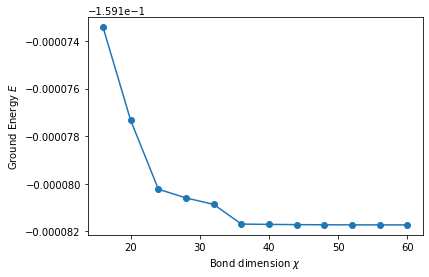

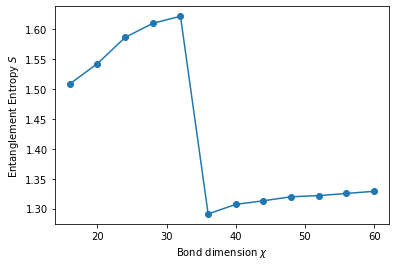

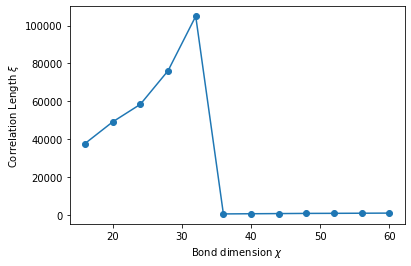

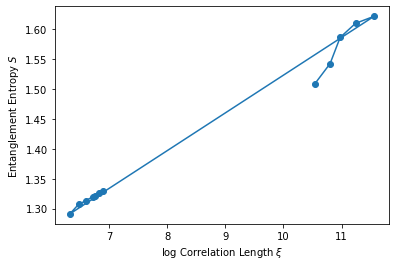

In [8]:
plot_results(data)

In [9]:
chi_list = data['chi_list']
energy_list = data['energy_list']
entropy_list = data['entropy_list']
correlation_list = data['correlation_list']

entropy_list = entropy_list[0:5]
correlation_list = correlation_list[0:5]
log_xi = np.log(correlation_list)

print((entropy_list[-1] - entropy_list[0])/(log_xi[-1] - log_xi[0]) * 6)

0.6634974884549044


## Finite Entanglement Scaling
The below content only works for the gapless cases

In [10]:
# from scipy.optimize import curve_fit

# def func(xi, c, a):
#     return (c / 6) * np.log(xi) + a

In [11]:
# xi = correlation_list
# log_xi = np.log(correlation_list)
# s = entropy_list
# fitParams, fitCovariances = curve_fit(func, xi, s)

In [12]:
# fitCovariances